# Boticario Product Classification

In [44]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting

%reload_ext autoreload
%autoreload 2
%matplotlib inline

Using fastai lib

In [118]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

In [46]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}tmp

Set model parameters:

In [47]:
PATH = "data/boti/"
sz=224 #resnet restriction
arch = resnet50
bs = 16

## Data

In [48]:
# aug_tfms = [RandomRotate(5),
#             RandomLighting(0.07, 0.07)]

In [49]:
tfms = tfms_from_model(arch, 
                       sz=sz,
                       aug_tfms=None
                       )

In [264]:
data = ImageClassifierData.from_paths(path=PATH, bs=bs,tfms=tfms, test_name='test', test_with_labels=True)


### Check data

In [244]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
#     ax.set_xticks(np.linspace(0, 224, 9))
#     ax.set_yticks(np.linspace(0, 224, 9))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    #top left: b[:2], bottom_right: b[-2:]
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [52]:
def sample(dataloader):
    x, y = next(iter(dataloader))
    x = to_np(x)
    y = to_np(y)
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i,ax in enumerate(axes.flat):

        image=data.trn_ds.denorm(x)[i]
        label= data.classes[y[i]]
        ax = show_img(image, ax=ax)
        draw_text(ax, (0,0), label)
    plt.tight_layout()

#### Training data

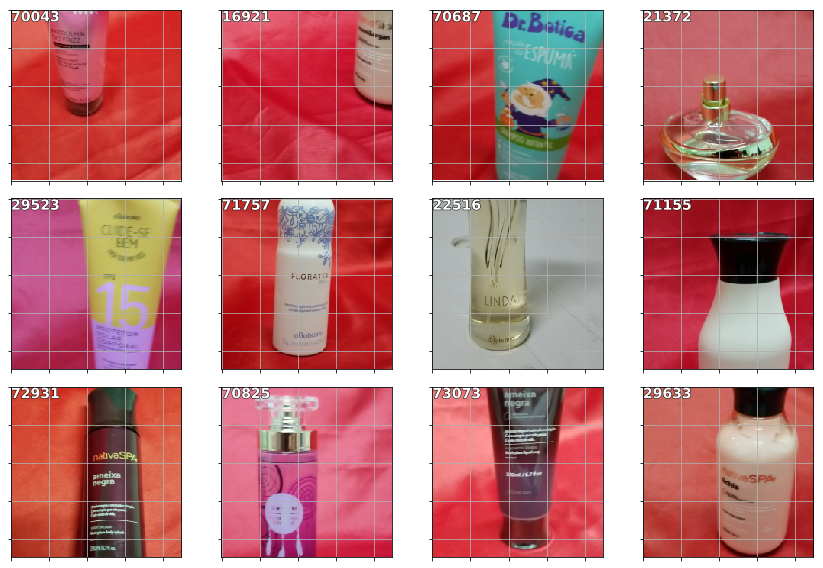

In [53]:
sample(data.trn_dl)

#### Validation data

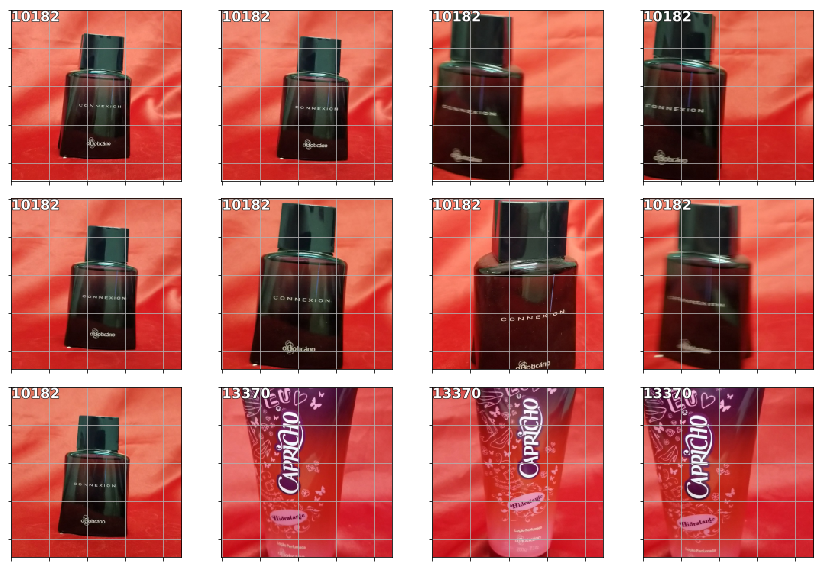

In [54]:
sample(data.val_dl)

#### Test data

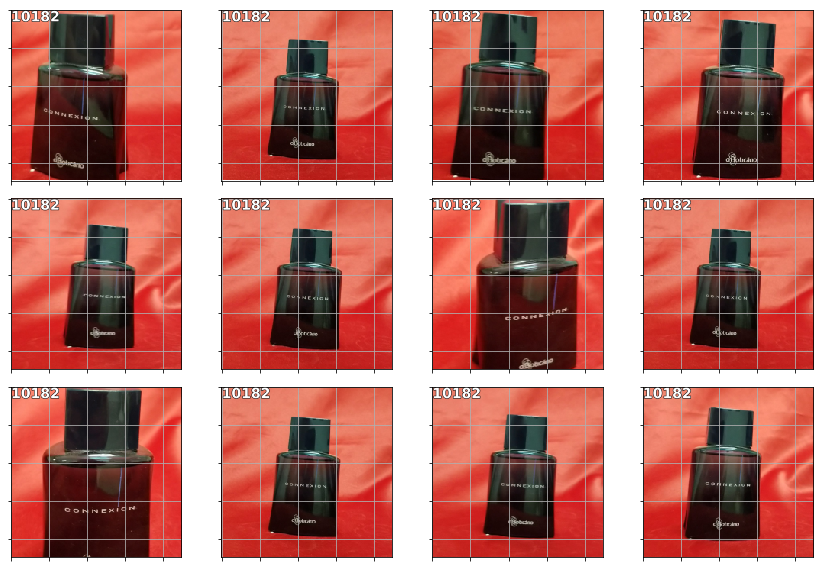

In [55]:
sample(data.test_dl)

## Model

Get a pretrained Resnet-50

In [56]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

Find optimal learning rate

In [57]:
learn.lr_find(start_lr=1e-3, end_lr=1e2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 54%|█████▍    | 307/571 [00:44<00:38,  6.85it/s, loss=9.07]

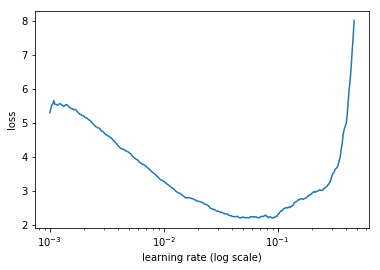

In [58]:
learn.sched.plot(n_skip=0, n_skip_end=0)

Train

In [59]:
learn.fit(0.05, 8)

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

  6%|▌         | 33/571 [00:04<01:20,  6.71it/s, loss=4.35]

Exception in thread Thread-23:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.740008   0.222136   0.934239  
    1      0.491072   0.120686   0.960544                    
    2      0.371491   0.121256   0.963174                    
    3      0.290347   0.072916   0.975888                    
    4      0.290636   0.063546   0.981587                    
    5      0.213959   0.043305   0.985533                    
    6      0.213353   0.02888    0.992986                    
    7      0.147686   0.024315   0.994301                    



[array([ 0.02431]), 0.99430074528715473]

## Check results

Run results for a validation batch

In [60]:
x,y = next(iter(data.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
y = to_np(y)
print (accuracy_np(preds,y))
preds = np.argmax(preds, -1)

1.0


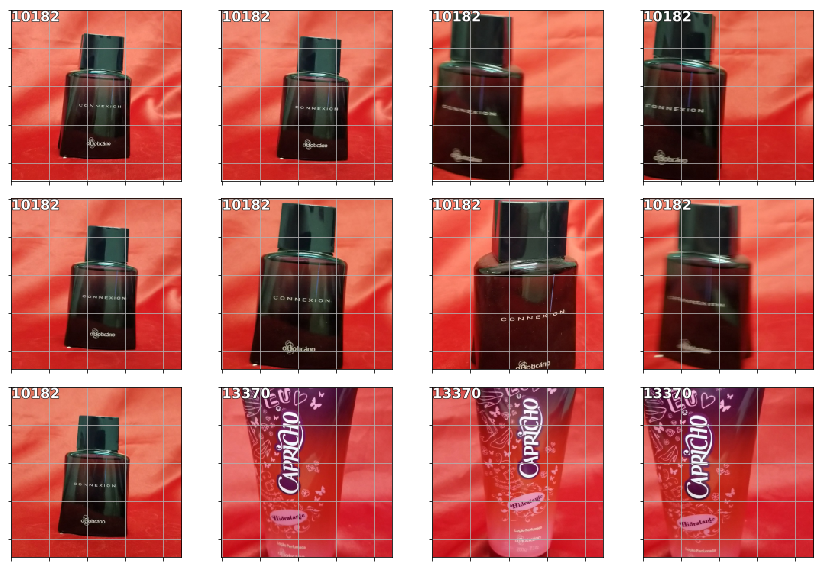

In [61]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=data.val_ds.denorm(x)[i]
    b = data.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

In [63]:
x,y = next(iter(data.test_dl))


In [64]:
dummy = predict_batch(learn.model, x)

In [65]:
probs = F.softmax(dummy, -1)


In [66]:
x,preds = to_np(x),to_np(probs)


In [67]:
y = to_np(y)


In [68]:
accuracy_np(preds,y)


1.0

In [69]:
preds = np.argmax(preds, -1)

In [70]:
(preds==y)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True], dtype=bool)

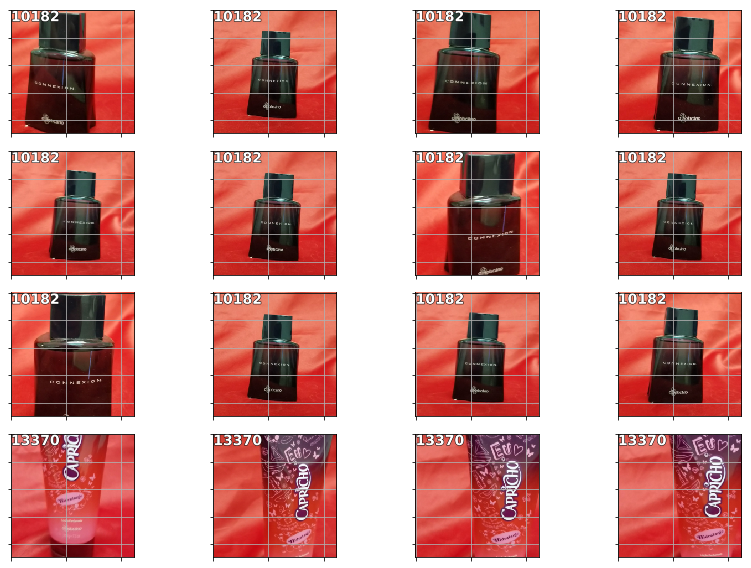

In [71]:
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=data.test_ds.denorm(x)[i]
    b = data.classes[preds[i]]
    c = data.classes[y[i]]
    if b!=c:
        b = b + '/'+c
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
    
plt.tight_layout()

Check with all test data set

In [72]:
log_preds,_ = learn.TTA(n_aug=1, is_test=True)
probs = np.mean(np.exp(log_preds),0)
preds = np.argmax(probs,axis=1)
targs = data.test_ds.y
targs = to_np(targs)

In [73]:
(preds==targs).mean()

0.99438990182328191

In [74]:
accuracy_np(probs, targs)

0.99438990182328191

## Improve

In [75]:
learn.fit(0.05, 5, cycle_len=1, cycle_mult=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.092228   0.008983   0.999123  
    1      0.111472   0.00913    0.998246                     
    2      0.086017   0.008148   0.997808                     
    3      0.1035     0.008604   0.997808                     
    4      0.132049   0.00678    0.999123                     



[array([ 0.00678]), 0.99912319158263918]

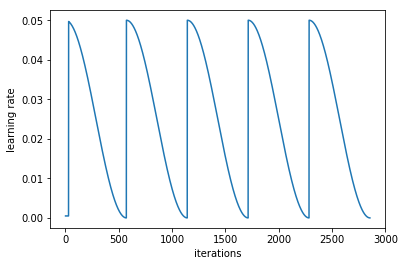

In [76]:
learn.sched.plot_lr()

In [77]:
log_preds,_ = learn.TTA(n_aug=1, is_test=True)
probs = np.mean(np.exp(log_preds),0)
targs = data.test_ds.y
targs = to_np(targs)
accuracy_np(probs, targs)

0.99894810659186539

In [218]:
preds = np.argmax(probs,axis=1)

In [219]:
np.where(preds!=targs)

(array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 12, 14, 15, 16, 17, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]),)

In [85]:
data.classes[preds[999]], data.classes[targs[999]]

('27691', '27080')

In [220]:
import glob

In [221]:
def getSamples(category, dataset):
  imgs = []
  search = PATH+dataset+'/'+category+'/*'
  filenames = glob.glob(search)
  fi = min(len(filenames), 8)
  for j in range(0, fi):
    fn = str(filenames[j])
    try:
        im = cv2.imread(str(fn))
        if im is None: raise OSError(f'File not recognized by opencv: {fn}')
    except Exception as e:
        raise OSError('Error handling image at: {}'.format(fn)) from e
    im = cv2.resize(im, (sz,sz))
    imgs.append(cv2.cvtColor(im, cv2.COLOR_BGR2RGB).astype(np.float32)/255)
  return imgs

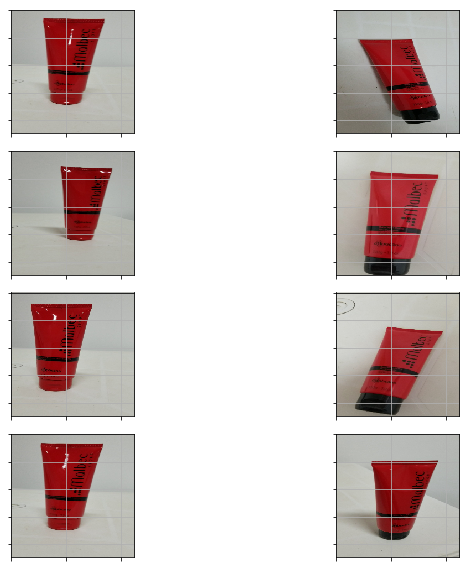

In [222]:
fig, axes = plt.subplots(4, 2, figsize=(12, 8))
impred = getSamples('27691', 'train')
imtarg = getSamples('27080', 'train')
for i,ax in enumerate(axes.flat):
    if (i%2)==0:
        ima=impred[i]
    else:
        ima=imtarg[i]
    b = data.classes[preds[i]]
    c = data.classes[y[i]]
    if b!=c:
        b = b + '/'+c
    ax = show_img(ima, ax=ax)
#     draw_text(ax, (0,0), b)
    
plt.tight_layout()

## Mudando o domínio das Imagens Teste

### Gerando o dataset de testes

In [238]:
df = pd.read_csv(PATH+"/mags/annotations.csv")

In [239]:
df.annotations[1]

"[{'label':'20601___COFFEE DES COL WOMAN 100ml V2','type':'rectangle','coordinates':{'height':374,'width':292,'x':152,'y':379}}]"

In [240]:
import json
import os

In [265]:
json_acceptable_string = df.annotations[1].replace("'", "\"")
csv = json.loads(json_acceptable_string)

In [266]:
csv

[{'coordinates': {'height': 374, 'width': 292, 'x': 152, 'y': 379},
  'label': '20601___COFFEE DES COL WOMAN 100ml V2',
  'type': 'rectangle'}]

In [299]:
len(data.classes)
for label in data.classes:
    directory = '{}mags_test/{}'.format(PATH, label)
    if not os.path.exists(directory):
          os.makedirs(directory)

In [300]:
for i in range(len(df.path)):
    imgfile = df.path[i].split('/')[-2:]
    imgfile = '/'.join(imgfile)
    imgfile = "data/boti/"+imgfile
    csv = json.loads(df.annotations[i].replace("'", "\""))
    for j in range(len(csv)):
        d = csv[j]
        label = d['label'][:5]
        dx = d['coordinates']['x']
        dy = d['coordinates']['y']
        dw = d['coordinates']['width']
        dh = d['coordinates']['height']
        name = imgfile.split("/")[-1]
        name = name.replace('.jpg', '')
        directory = '{}mags_test/{}'.format(PATH, label)
        file = '{}/{}-{}.jpg'.format(directory, name, j)
        im = cv2.imread(imgfile)
#         im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        h2, w2 = int (dh/2), int (dw/2)
        im = im[dy-h2:dy+h2, dx-w2:dx+w2] 
        cv2.imwrite(file, im)

In [366]:
PATH = "data/boti/"
sz=224 #resnet restriction
arch = resnet50
bs = 16

In [367]:
aug_tfms = [RandomRotate(90)]


In [368]:
tfms = tfms_from_model(arch, 
                       sz=sz,
                       aug_tfms=aug_tfms,
                       crop_type=CropType.NO
                       )

In [369]:
data = ImageClassifierData.from_paths(path=PATH, bs=bs,tfms=tfms, test_name='mags_test', test_with_labels=True)

### Treinando Modelo

In [370]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 54%|█████▍    | 308/571 [00:47<00:40,  6.55it/s, loss=10.3]

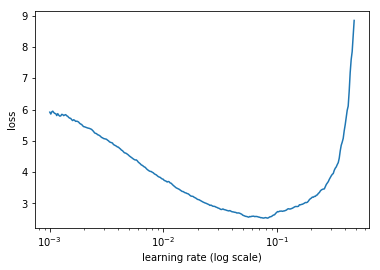

In [371]:
learn.lr_find(start_lr=1e-3, end_lr=1e2)
learn.sched.plot(n_skip=0, n_skip_end=0)

In [372]:
learn.fit(0.02, 8)

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

  0%|          | 2/571 [00:00<03:20,  2.84it/s, loss=5.95]

Exception in thread Thread-82:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.661477   0.355907   0.89829   
    1      0.411786   0.131888   0.962297                    
    2      0.376829   0.122056   0.964051                    
    3      0.247268   0.061029   0.97808                     
    4      0.244555   0.06778    0.97808                     
    5      0.206966   0.073521   0.978957                    
    6      0.248295   0.059362   0.982902                    
    7      0.196894   0.022354   0.992547                    



[array([ 0.02235]), 0.99254712845243309]

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.126139   0.013202   0.996054  
    1      0.195317   0.011127   0.997808                     
    2      0.118977   0.00911    0.99737                      
    3      0.09844    0.009415   0.996054                     
    4      0.087109   0.008772   0.998246                     



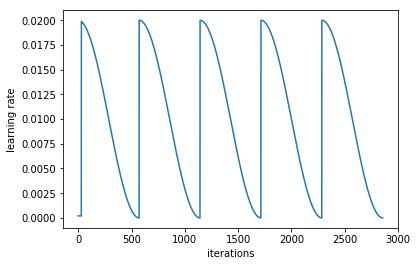

In [373]:
learn.fit(0.02, 5, cycle_len=1, cycle_mult=1)
learn.sched.plot_lr()

In [374]:
log_preds,_ = learn.TTA(n_aug=7, is_test=True)
probs = np.mean(np.exp(log_preds),0)
targs = data.test_ds.y
targs = to_np(targs)
accuracy_np(probs, targs)

0.47169811320754718

In [393]:
probs, probs.shape

(array([[ 0.00031,  0.     ,  0.     , ...,  0.00002,  0.     ,  0.     ],
        [ 0.00035,  0.00006,  0.00007, ...,  0.00038,  0.00001,  0.00051],
        [ 0.01604,  0.00023,  0.     , ...,  0.00003,  0.     ,  0.00011],
        ..., 
        [ 0.0003 ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
        [ 0.0001 ,  0.00026,  0.00002, ...,  0.00128,  0.00015,  0.     ],
        [ 0.00006,  0.00016,  0.     , ...,  0.     ,  0.     ,  0.00001]], dtype=float32),
 (53, 168))

In [394]:
probs_sorted = np.argsort(probs, axis=1)
probs_sorted.shape, targs.shape
preds = np.argmax(probs, 1)
preds

array([ 62,  52,  51,  76,  10,  11,  10,  57,  21,  22,  10,  43,  48,  50,  50,  50,  57,  64,  60,  60,
        60,  74,  75,  11,  82,  89, 125,  89,  62,  92,  92,  60,  91, 102,  43,  11, 104, 107, 108, 141,
        10, 115, 148,  10, 119, 122, 125,  98, 114, 141,  43, 110,  64])

In [416]:
preds1=probs_sorted[:,-1]
preds2=probs_sorted[:,-2]
preds3=probs_sorted[:,-3]
preds4=probs_sorted[:,-4]
preds5=probs_sorted[:,-5]

In [404]:
(preds1==targs).mean(), (preds2==targs).mean()

(0.47169811320754718, 0.18867924528301888)

In [419]:
((preds1==targs) | (preds2==targs) |(preds3==targs)).mean()

0.73584905660377353

In [425]:
e = np.asarray(np.where(preds!=targs))
e, len(e[0])

(array([[ 0,  1,  2,  3,  6,  7, 10, 14, 15, 17, 23, 25, 26, 28, 31, 32, 34, 35, 39, 40, 42, 43, 45, 47, 48,
         50, 51, 52]]), 28)

In [384]:
e[0,5], len(e[0])

(7, 28)

In [443]:
probs[e[0]].mean()

0.0059523815

In [430]:
a = np.setdiff1d(np.array(range(probs.shape[0])), e)

In [444]:
(np.asarray(probs[a])).mean()

0.0059523815

In [378]:
data.classes[preds[1]], data.classes[targs[1]]

('25477', '19685')

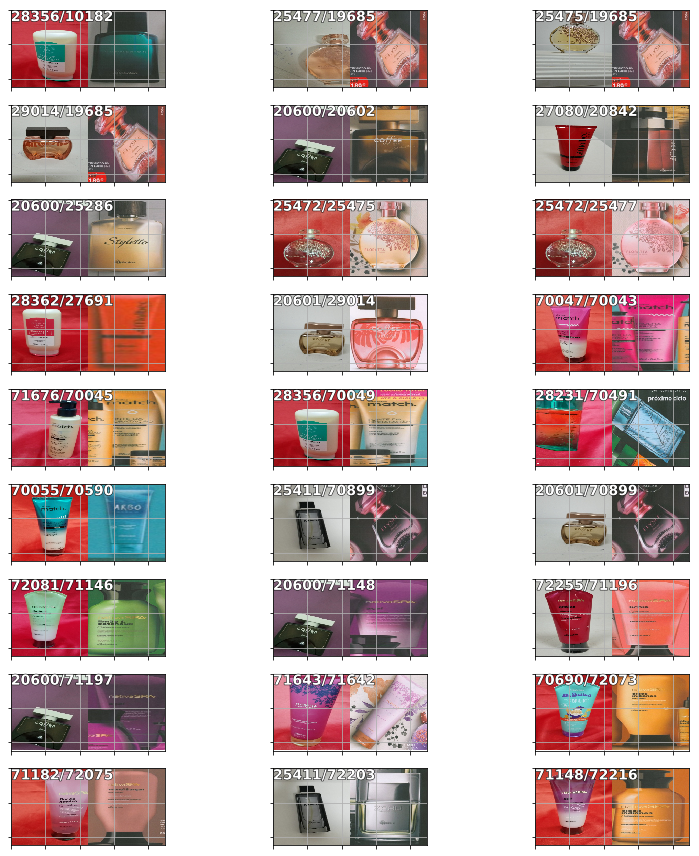

In [386]:
fig, axes = plt.subplots(9, 3, figsize=(12, 12))

for i,ax in enumerate(axes.flat):
    predcat = data.classes[preds[e[0,i]]]
    targcat = data.classes[targs[e[0,i]]]
    impred = getSamples(predcat, 'train')[0]
    imtarg = getSamples(targcat, 'mags_test')[0]
    im = np.hstack([impred, imtarg])
    ax = show_img(im, ax=ax)
    draw_text(ax, (0,0), predcat+'/'+targcat)

plt.tight_layout()
    
